Eleonora Pura - 17-732-678

In [6]:
import networkx as nx
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import re
import statistics
import glob
from NEMtropy import UndirectedGraph, DirectedGraph
from NEMtropy.network_functions import build_adjacency_from_edgelist
from NEMtropy import matrix_generator
import warnings
warnings.filterwarnings('ignore')

<h1>A06.1 - Exponential Random Graph Models</h1>

<b>Task</b>: For the World Trade Web dataset, fit different ERGM-based Configuration Models and compare basic network metrics with null models

For each of the WTW networks provided:
+ measure the average clustering and reciprocity coefficients
+ fit the Undirected Binary CM and Directed Binary CM
+ sample 10 networks from the obtained distributions and measure clustering and reciprocity (for the Directed ones)
+ plot clustering and reciprocity as functions of time, comparing the real value with the average from the sampled networks


In [7]:
filenames = [filename[5:] for filename in glob.glob('Data/*.graphml')]
filenames
years = []

years = [int("".join(re.findall(r'\d+', file))) for file in filenames]

In [8]:
avg_clustering_real = []
reciprocity_real = []
avg_clustering_sample = []
reciprocity_sample = []
for filename in filenames:
    g = nx.read_graphml('data/{}'.format(filename))
    
    avg_clustering_real.append(nx.average_clustering(g))
    reciprocity_real.append(nx.reciprocity(g))
    
    adj_g = nx.to_numpy_array(g)
    
    
    ug = UndirectedGraph(adj_g)
    dg = DirectedGraph(adj_g)
    
    clust = []
    rec = []
    
    dg.solve_tool(model="dcm_exp")
    dg.ensemble_sampler(10, cpu_n=1, output_dir="samples/ex1/")
    for i in range(10):
        edgelist_ens = np.loadtxt(f"samples/ex1/{i}.txt")
        net = nx.Graph()
        net.add_edges_from(edgelist_ens)
        clust.append(nx.average_clustering(net))
        rec.append(nx.reciprocity(net))
        

    avg_clustering_sample.append(statistics.mean(clust))
    reciprocity_sample.append(statistics.mean(rec))
    


solution error = 1.9590018496273842e-09

solution error = 5.1409259071988345e-09

solution error = 2.9426381331632e-09

solution error = 4.607581871596267e-09

solution error = 1.8271748558618128e-09

solution error = 2.2578205971512944e-09

solution error = 2.7879707431566203e-09

solution error = 2.4880648652469972e-09

solution error = 4.412768817019241e-09

solution error = 3.4770053503052623e-09

solution error = 2.3799486825737404e-09


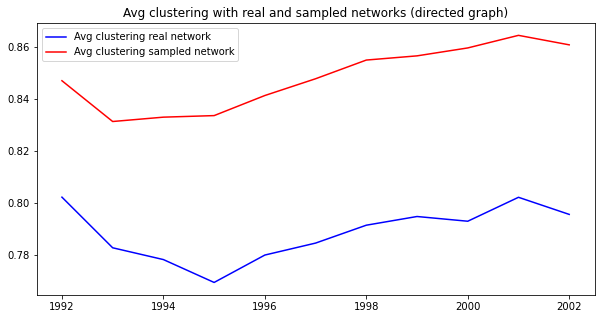

In [9]:
plt.figure(3, figsize=(10,5))    
plt.title("Avg clustering with real and sampled networks (directed graph)")
plt.plot(years, avg_clustering_real, c='b', label="Avg clustering real network")
plt.plot(years, avg_clustering_sample, c='r', label="Avg clustering sampled network")
plt.legend()
plt.show()

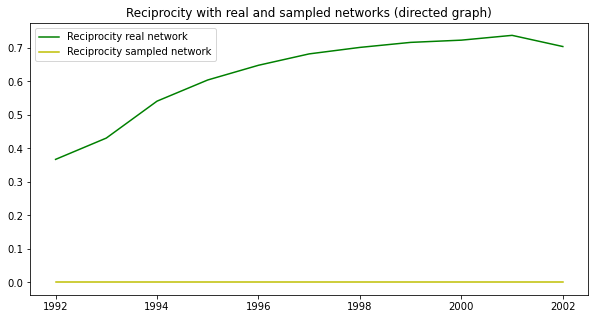

In [10]:
plt.figure(3, figsize=(10,5))    
plt.title("Reciprocity with real and sampled networks (directed graph)")

plt.plot(years, reciprocity_real, c='g', label="Reciprocity real network")
plt.plot(years, reciprocity_sample, c='y', label="Reciprocity sampled network")

plt.legend()
plt.show()

<h1>A06.2 - Weighted ERGMs</h1>

Task: Repeat the analysis of point 1 with weighted networks

+ measure strength assortativity coefficient on the data
+ fit the Undirected Enhanced CM and Directed Enhanced CM using the CReMa method
+ sample 10 networks from the obtained distributions and measure strength assortativity
+ plot strength assortativity as a function of time, comparing the real value with the average from the sampled networks
+ in the directed case, plot all pairs of assortativity (in-in, in-out, out-out)



In [11]:
assortativity_real = []
assortativity_sample_und = []
assortativity_sample_dir_in_in = []
assortativity_sample_dir_in_out = []
assortativity_sample_dir_out_out = []
for filename in filenames:
    g = nx.read_graphml('data/{}'.format(filename))
    
    assortativity_real.append(nx.degree_assortativity_coefficient(g))
    
    
    adj_weigh = matrix_generator.random_weighted_matrix_generator_uniform_custom_density(n=g.number_of_nodes(),
                                                                                         sym=True,
                                                                                         sup_ext=g.number_of_nodes(),
                                                                                         intweights=True)
    

    # Undirected    
    ugraph = UndirectedGraph(adj_weigh)
    ugraph.solve_tool(model="crema",
                     method="newton",
                     initial_guess="random",
                     adjacency="cm_exp",
                     method_adjacency="newton")
    
    ugraph.ensemble_sampler(10, cpu_n=1, output_dir='samples/ex2/undir/')
    
    
    
    # Directed
    dgraph = DirectedGraph(adj_weigh)
    dgraph.solve_tool(model="crema",
                     method="newton",
                     initial_guess="random",
                     adjacency="dcm_exp",
                     method_adjacency="newton")
    
    ugraph.ensemble_sampler(10, cpu_n=1, output_dir='samples/ex2/dir/')
        
        
    assortativity_und = []
    assortativity_dir_in_in = []
    assortativity_dir_in_out = []
    assortativity_dir_out_out =[]
    for i in range(10):
        # to read the adjacency list we now need a method that maps it to a weighted adjacency matrix
        edgelist_ens_und = np.loadtxt("samples/ex2/undir/{}.txt".format(i))
        edgelist_ens_dir = np.loadtxt("samples/ex2/dir/{}.txt".format(i))

        ens_adj_und = build_adjacency_from_edgelist(edgelist = edgelist_ens_und,
                                                    is_directed = False,
                                                    is_sparse = False,
                                                    is_weighted = True)
        
        ens_adj_dir = build_adjacency_from_edgelist(edgelist=edgelist_ens_dir,
                                                    is_directed=True,
                                                    is_sparse=False,
                                                    is_weighted=True)

        # and generate a networkx graph from it
        Gund= nx.from_numpy_array(ens_adj_und)
        Gdir= nx.from_numpy_array(ens_adj_dir, create_using=nx.DiGraph)
        
        assortativity_und.append(nx.degree_assortativity_coefficient(Gund, weight='weigth'))
        assortativity_dir_in_in.append(nx.degree_assortativity_coefficient(Gdir, x='in', y='in', weight='weigth'))
        assortativity_dir_in_out.append(nx.degree_assortativity_coefficient(Gdir, x='in', y='out', weight='weigth'))
        assortativity_dir_out_out.append(nx.degree_assortativity_coefficient(Gdir, x='out', y='out', weight='weigth'))
        
    assortativity_sample_und.append(statistics.mean(assortativity_und))
    assortativity_sample_dir_in_in.append(statistics.mean(assortativity_dir_in_in))
    assortativity_sample_dir_in_out.append(statistics.mean(assortativity_dir_in_out))
    assortativity_sample_dir_out_out.append(statistics.mean(assortativity_dir_out_out))


solution error = 1.0750096635092632e-07

solution error = 9.322320693172514e-12

solution error = 4.120661500905953e-08

solution error = 0.003629940240216456

solution error = 0.0005357352108603664

solution error = 1.5297985100914957e-11

solution error = 2.374873631083574e-09

solution error = 1.7184582645768387e-09

solution error = 9.365664972449395e-07

solution error = 1.2721557141048834e-09

solution error = 5.418548347790875e-07

solution error = 2.2737367544323206e-12

solution error = 9.472936213228422e-08

solution error = 2.381503577453259e-05

solution error = 3.856496988419167e-08

solution error = 9.902401885142353e-07

solution error = 2.607776750096491e-08

solution error = 1.025489382300293e-08

solution error = 0.0003746042432339891

solution error = 1.8243016484120744e-06

solution error = 1.5783768958499422e-07

solution error = 2.2737367544323206e-12


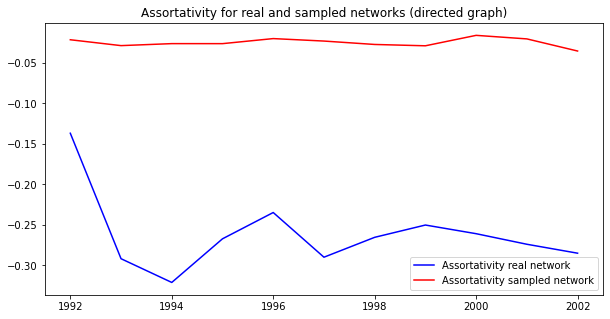

In [12]:
plt.figure(3, figsize=(10,5))    
plt.title("Assortativity for real and sampled networks (directed graph)")
plt.plot(years, assortativity_real, c='b', label="Assortativity real network")
plt.plot(years, assortativity_sample_und, c='r', label="Assortativity sampled network")

plt.legend()
plt.show()
    

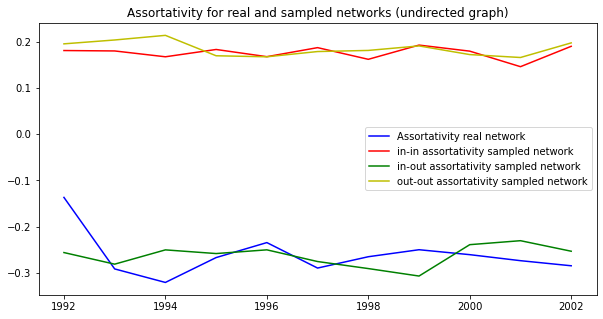

In [13]:
plt.figure(3, figsize=(10,5))    
plt.title("Assortativity for real and sampled networks (undirected graph)")
plt.plot(years, assortativity_real, c='b', label="Assortativity real network")
plt.plot(years, assortativity_sample_dir_in_in, c='r', label="in-in assortativity sampled network")
plt.plot(years, assortativity_sample_dir_in_out, c='g', label="in-out assortativity sampled network")
plt.plot(years, assortativity_sample_dir_out_out, c='y', label="out-out assortativity sampled network")

plt.legend()
plt.show()


<h1>A06.3 - Drawing conclusions</h1>

Task: write a short paragraph to draw conclusions about the structure of the World Trade Web based on the ERGM inferential approach

You should include at least the following points:
+ Comment on the interpretation of the clustering and reciprocity coefficients found in the original data
+ Comment on the interpretation of strength assortativity for this dataset
+ Comment on the conclusions you can draw via the inference of the UBCM, DBCM and DECM models


<b>Conclusions</b>:

+ Clustering increased during the years, this means that two countries that have a trade are more likely to trade also with their other respective trading partners as time increases. The same is true for reciprocity: over the years the relations with countries tend to be more mutual, as the trust in each other increases.

+ Assortativity decreased from 1993 to 1994, increased again until 1996 where it started to decrease again. In 1997 it started to increase again, but it decreased again from 1999 onwards. When the assortativity decrease it means that the most powerful contries in terms of trades is not likely to trade with their competitors.

+ It was not asked to test the sample with UBCM but only with DBCM. It was seen that this model it is more suitable for predicting the average clustering rather than the reciprocity. For the DECM model, the sample with the in-out assortativity was the more efficient for predicting the assortativity of the real network